# Spotify Song Suggester

## The Problem:
Need to create a model to give predictions of songs that a user might like based on music they already like.

## Resources:
- [DS PT Schedule / Milestones](https://www.notion.so/f30da0c13d5247289bd5ade8d95af4a8?v=c97929c27fe24af780928a5a91a8b095)
- [DS Unit 3 Rubric](https://www.notion.so/Data-Science-Unit-3-Rubric-455c04d97fb840c6b75d46e8052a5275)
- [DS Unit 4 Rubric](https://www.notion.so/Data-Science-Unit-4-Rubric-1f7381be7b924da2a83c086c2bf97d3b)

## The Data:
Looking for data that not only gives the artist and title of a song, but the lyrics too.

### Possible Datasets:
- most_popular_spotify_songs.csv
- [billboard-lyrics-spotify.csv](https://github.com/walkerkq/musiclyrics/blob/master/billboard_lyrics_1964-2015.csv)
- [Spotify API](https://developer.spotify.com/documentation/web-api/quick-start/)
- [musiXmatch Dataset API](http://millionsongdataset.com/musixmatch/)
- Scrape the web for lyrics to match to Spotify song list.

In [1]:
# Install squarify
!pip install squarify

In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
from collections import Counter

# Sci-Kit Learn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer

# NLP
import re
from nltk.stem import PorterStemmer
import spacy
from spacy.tokenizer import Tokenizer

# PLotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec

In [3]:
# Read in dataset
song_df = pd.read_csv('https://raw.githubusercontent.com/Spotify-DSPT-158/Build-Week-Spotify/main/spotify_songs.csv')

# Peak at the dataset
print(song_df.shape)
song_df.head()

(18454, 25)


,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [4]:
# Drop columns not needed for our problem
songs = song_df.drop(columns=['track_album_id', 'track_album_name', 'playlist_id'])
print(songs.shape)
songs.head()

(18454, 22)


,track_id,track_name,track_artist,lyrics,track_popularity,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,2001-01-01,Pinoy Classic Rock,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,2012-10-29,Christmas Soul,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,2019-09-22,K-Party Dance Mix,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [5]:
# Rename features to make it easier to work with
songs = songs.rename(columns={'track_id': 'id', 'track_name': 'title' , 
                              'track_artist': 'artist', 
                              'track_popularity': 'popularity',
                              'track_album_release_date': 'release_date',
                              'playlist_name': 'playlist', 
                              'playlist_genre': 'genre',
                              'playlist_subgenre': 'subgenre'})

songs.head()

,id,title,artist,lyrics,popularity,release_date,playlist,genre,subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,2001-01-01,Pinoy Classic Rock,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,2012-10-29,Christmas Soul,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,2019-09-22,K-Party Dance Mix,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [6]:
# Peak a lyrics value
songs.lyrics[2]

'NA Yeah, Spyderman and Freeze in full effect Uh-huh You ready, Ron? I\'m ready You ready, Biv? I\'m ready, Slick, are you? Oh, yeah, break it down NA Girl, I, must (warn you) I sense something strange in my mind Situation is (serious) Let\'s cure it cause we\'re running out of time It\'s oh, so (beautiful) Relationships they seem from the start It\'s all so (deadly) When love is not together from the heart It\'s drivin\' me out of my mind! That\'s why it\'s HARD for me to find Can\'t get it out of my head! Miss her, kiss her, love her(Wrong move you\'re dead!) That girl is (poison)...Never trust a big butt and smile That girl is (poison)..("POISON!!") NA (-caution) Before I start to meet a fly girl, you know? Cause in some (portions) You\'ll think she\'s the best thing in the world She\'s so - (fly) She\'ll drive you right out of your mind And steal your heart when you\'re blind Beware she\'s schemin\', she\'ll make you think you\'re dreamin\' YOU\'LL fall in love and you\'ll be screa

In [7]:
# Look at values in lyrics
songs['lyrics'].value_counts()

Lyrics for this song have yet to be released. Please check back once the song has been released.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [8]:
# Remove rows that have no lyrics or "Instrumental"
songs = songs[songs['lyrics'].notna()]
no_lyrics_yet = songs[songs['lyrics'] == 'Lyrics for this song have yet to be released. Please check back once the song has been released.'].index
songs.drop(no_lyrics_yet, inplace=True)
no_lyrics_NA = songs[songs['lyrics'] == 'NA NA'].index
songs.drop(no_lyrics_NA, inplace=True)
print(songs.shape)

(18127, 22)


In [9]:
# Create function to tokenize a list of words
def tokens(text):
  '''
  Parses a string into a list of sementic units (words)0

  Args:
    text (str): A string of values to be tokenized

  Returns:
    list of tokens
  '''

  # remove all non-alpha numeric characters
  tokens = re.sub('[^a-z A-Z 0-9]', '', text)
  
  # Lowercase all and split on spaces
  tokens = tokens.lower().split()

  return tokens

In [10]:
# Tokenize the lyrics
songs['tokens'] = songs['lyrics'].apply(tokens)

# Compare the lyrics to tokens
songs[['lyrics', 'tokens']][:5]

,lyrics,tokens
0,Minsan pa Nang ako'y napalingon Hindi ko alam ...,"[minsan, pa, nang, akoy, napalingon, hindi, ko..."
1,"The trees, are singing in the wind The sky blu...","[the, trees, are, singing, in, the, wind, the,..."
2,"NA Yeah, Spyderman and Freeze in full effect U...","[na, yeah, spyderman, and, freeze, in, full, e..."
3,I really can't stay Baby it's cold outside I'v...,"[i, really, cant, stay, baby, its, cold, outsi..."
4,Get up out of my business You don't keep me fr...,"[get, up, out, of, my, business, you, dont, ke..."


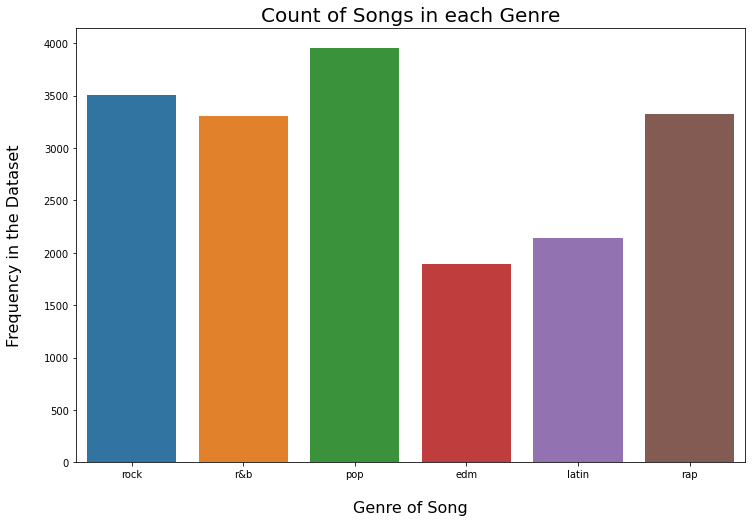

In [11]:
# Graph the count of songs per genre
plt.figure(figsize=(12,8), facecolor='white')
ax = sns.countplot(x='genre', data=songs)
plt.title('Count of Songs in each Genre', fontdict={'size':20})
plt.xlabel('\nGenre of Song', fontdict={'size':16})
plt.ylabel('Frequency in the Dataset\n', fontdict={'size':16});

This dataset (spotify_songs.csv) is not diverse in genres but has lyrics and is large enough to train a descent model on.

In [12]:

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()  # the total word count per document (aka row)
    appears_in = Counter()  # the total unique words that appear in the document (aka row)

    total_docs = len(docs)  # the total number of documents (aka rows)

    for doc in docs:
        word_counts.update(doc)  # gives the word cound for each document
        appears_in.update(set(doc))  # gives the unique words in a single document

    temp = zip(word_counts.keys(), word_counts.values())  # creates a 2d list of the word and it's count

    wc = pd.DataFrame(temp, columns = ['word', 'count'])  # creates a DataFrame with the word and the number of instances

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()  # ranks the words and returns the sum of each word

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)  # gives the percentage of how often the words appear throughout the whole dataset

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()  # sorts the values by the count

    t2 = zip(appears_in.keys(), appears_in.values())  # creates a 2d list of the words and how often they appear
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])  # turns the above into a DataFrame
    wc = ac.merge(wc, on='word')  # merges the 2 DataFrames together

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)  # gives the percentage of how often it appears in the document

    return wc.sort_values(by='rank')  # sorts the values by the rank column.

In [13]:
# Use the Function
wc = count(songs['tokens'])
print(wc.shape)
wc.head()

(110885, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
100,i,14430,250944,1.0,0.032518,0.032518,0.796050
97,you,14277,245384,2.0,0.031797,0.064315,0.787610
80,the,14873,222773,3.0,0.028867,0.093183,0.820489
79,me,14492,147350,4.0,0.019094,0.112277,0.799470
91,a,14836,134948,5.0,0.017487,0.129764,0.818448


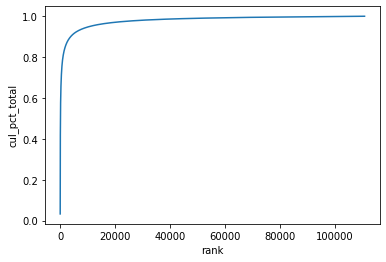

In [14]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [15]:
# What is the percentage of the top 100 words vs all words in dataframe?
wc[wc['rank'] <= 100]['cul_pct_total'].max()

0.515059103214125

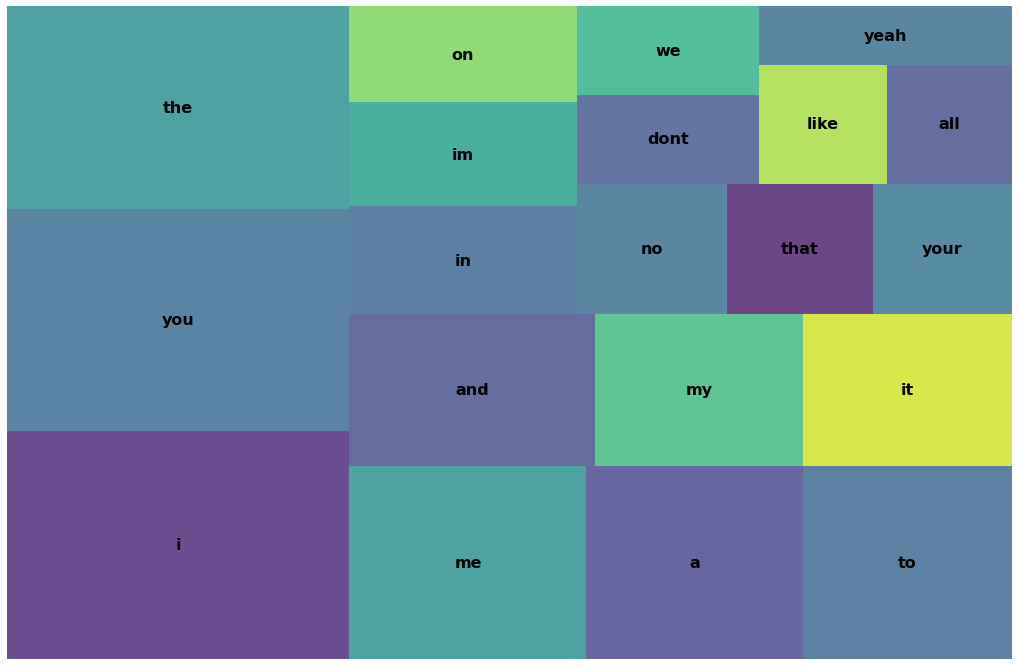

In [16]:
# Visualize the top 20 words:
wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(18,12))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8, text_kwargs={'size': 16, 'weight': 'bold'})
plt.axis('off')
plt.show()

#### This is the dataset we have decided to use.

In [17]:
# Look at another dataset and preform EDA
most_pop_songs = pd.read_csv('https://raw.githubusercontent.com/Spotify-DSPT-158/Build-Week-Spotify/main/most_popular_spotify_songs.csv')
print(most_pop_songs.shape)
most_pop_songs.head()

(75022, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,0.000000,D,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930
1,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.3230,0.685,186467,0.610,0.000000,C,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230
2,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.0675,0.762,199520,0.520,0.000004,F,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862
3,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.3600,0.563,240597,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680
4,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.5960,0.653,213947,0.621,0.000000,B,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660


In [18]:
# Look at all the features
most_pop_songs.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

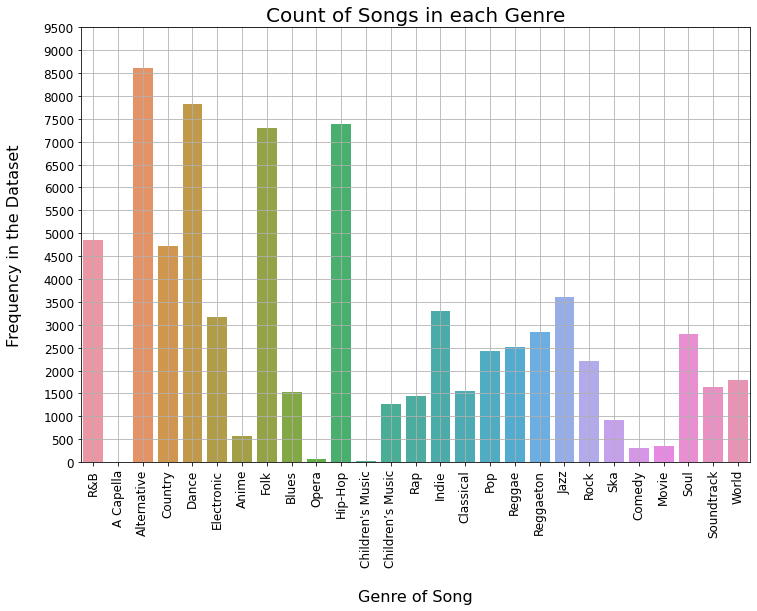

In [19]:
# Plot the count of songs in each genre
plt.figure(figsize=(12,8), facecolor='white')
ax = sns.countplot(x='genre', data=most_pop_songs)
plt.title('Count of Songs in each Genre', fontdict={'size':20})
plt.xlabel('\nGenre of Song', fontdict={'size':16})
plt.xticks(rotation=90, size=12)
plt.ylabel('Frequency in the Dataset\n', fontdict={'size':16})
plt.yticks(np.arange(0, 10000, 500), size=12)
plt.grid();

This dataset (most_popular_spotify_songs.csv) is more diverse but no lyrics.

In [20]:
# Look at the stats of the numerically features
most_pop_songs.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,75022.000000,75022.000000,75022.000000,7.502200e+04,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000
mean,52.326757,0.286114,0.590045,2.338447e+05,0.609805,0.098790,0.188244,-8.127492,0.095000,119.785346,0.469266
std,8.930855,0.305384,0.168050,8.315542e+04,0.230312,0.249359,0.158109,4.636775,0.108138,29.795567,0.244772
min,41.000000,0.000001,0.058100,3.009300e+04,0.000234,0.000000,0.009670,-47.046000,0.022200,31.689000,0.017600
25%,45.000000,0.029300,0.483000,1.910228e+05,0.460250,0.000000,0.096200,-9.682750,0.035600,95.431750,0.274000
50%,50.000000,0.158000,0.602000,2.213730e+05,0.638000,0.000015,0.123000,-6.979000,0.049700,119.048000,0.459000
75%,58.000000,0.485000,0.713000,2.604368e+05,0.792000,0.005727,0.228000,-5.198000,0.102000,139.997000,0.659000
max,100.000000,0.996000,0.986000,5.488000e+06,0.999000,0.994000,1.000000,1.585000,0.960000,242.903000,0.992000


In [21]:
# Check for null values
most_pop_songs.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [22]:
# Make a copy of the dataframe to work with
song_df = most_pop_songs.copy()

# Combine artist names, genre, and tracks into one feature
song_df['text'] = song_df[['genre', 'artist_name', 
                           'track_name']].apply(lambda x: ' '.join(x), 
                                                axis=1)

# Look at the new dataframe
song_df.head(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,text
0,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,0.000000,D,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930,R&B Mary J. Blige Be Without You - Kendu Mix
1,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.3230,0.685,186467,0.610,0.000000,C,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230,R&B Rihanna Desperado
2,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.0675,0.762,199520,0.520,0.000004,F,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862,R&B Yung Bleu Ice On My Baby (feat. Kevin Gate...
3,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.3600,0.563,240597,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680,R&B Surfaces Heaven Falls / Fall on Me
4,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.5960,0.653,213947,0.621,0.000000,B,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660,R&B Olivia O'Brien Love Myself
5,R&B,ELHAE,Needs,7KdRu0h7PQ0Ecfa37rUBzW,61,0.6610,0.510,205640,0.331,0.000000,B,0.1230,-13.073,Minor,0.0895,124.657,4/4,0.2250,R&B ELHAE Needs
6,R&B,Nao,Make It Out Alive (feat. SiR),21Ft8ME799DMZjxNwmui6Z,64,0.6670,0.670,239147,0.649,0.000130,C,0.1090,-7.426,Minor,0.0875,147.935,4/4,0.6180,R&B Nao Make It Out Alive (feat. SiR)
7,R&B,Frank Ocean,Seigfried,1BViPjTT585XAhkUUrkts0,66,0.9750,0.377,334570,0.255,0.000208,E,0.1020,-11.165,Minor,0.0387,125.004,5/4,0.3700,R&B Frank Ocean Seigfried
8,R&B,Layton Greene,Roll In Peace,33YFwLJbAdgePluIuEVa9p,60,0.7200,0.523,170343,0.507,0.000000,G,0.0774,-6.448,Minor,0.2250,140.368,4/4,0.7000,R&B Layton Greene Roll In Peace
9,R&B,Usher,You Make Me Wanna...,47TqCCnEliDp8NRDyIQoQq,69,0.0359,0.761,219120,0.639,0.000000,F,0.0945,-7.577,Minor,0.0539,164.088,4/4,0.9220,R&B Usher You Make Me Wanna...


In [23]:
# Look at a random observation
song_df.loc[736]

genre                                             Alternative
artist_name                                         Lifehouse
track_name                                Hanging By A Moment
track_id                               0wqOReZDnrefefEsrIGeR4
popularity                                                 63
acousticness                                         0.000983
danceability                                            0.531
duration_ms                                            216067
energy                                                  0.855
instrumentalness                                            0
key                                                        C#
liveness                                               0.0716
loudness                                                -4.95
mode                                                    Major
speechiness                                            0.0352
tempo                                                 124.578
time_sig

In [25]:
# Tokenize the text feature
song_df['tokens'] = song_df['text'].apply(tokens)

# Compare the text to tokens
song_df[['text', 'tokens']][:5]

,text,tokens
0,R&B Mary J. Blige Be Without You - Kendu Mix,"[rb, mary, j, blige, be, without, you, kendu, ..."
1,R&B Rihanna Desperado,"[rb, rihanna, desperado]"
2,R&B Yung Bleu Ice On My Baby (feat. Kevin Gate...,"[rb, yung, bleu, ice, on, my, baby, feat, kevi..."
3,R&B Surfaces Heaven Falls / Fall on Me,"[rb, surfaces, heaven, falls, fall, on, me]"
4,R&B Olivia O'Brien Love Myself,"[rb, olivia, obrien, love, myself]"


In [26]:
# Get the word count on the tokenized text
wc = count(song_df['tokens'])
print(wc.shape)
wc.head()

(33296, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
60,the,12218,13421,1.0,0.029203,0.029203,0.162859
454,alternative,8619,8619,2.0,0.018754,0.047957,0.114886
360,dance,8026,8072,3.0,0.017564,0.065521,0.106982
10175,hiphop,7388,7391,4.0,0.016082,0.081603,0.098478
10699,folk,7304,7306,5.0,0.015897,0.097501,0.097358


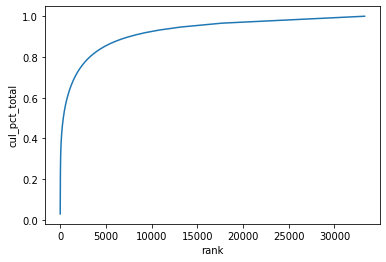

In [27]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [28]:
# What is the percentage of the top 100 words vs all words in dataframe?
wc[wc['rank'] <= 100]['cul_pct_total'].max()

0.3784444792591433

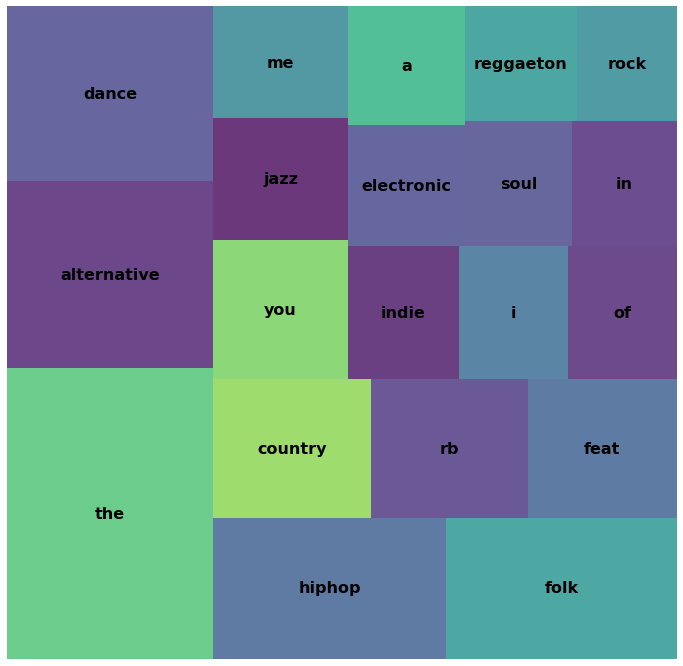

In [30]:
# Visualize the top 20 words:
wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(12,12))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8, text_kwargs={'size': 16, 'weight': 'bold'})
plt.axis('off')
plt.show()

In [ ]:
# # Install the spacy medium library
# !python -m spacy download en_core_web_lg

In [ ]:
# # Load the spacy medium library
# nlp = spacy.load('en_core_web_lg')

# # Create a function to get lemmas
# def lemma_creator(text):
#     lemmas = []  # Empty list to hold lemmas
#     process_text = nlp(text)  # Process text using spacy

#     # Iterate through the processed text
#     for token in process_text:
#         if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
#             lemmas.append(token.lemma_)  # Add to the lemmas list for each title
#     return ' '.join(lemmas)

# # Use function above to create a lemmas feature
# most_pop_songs['lemmas'] = most_pop_songs['text'].apply(lemma_creator)

# # Verify the function worked properly
# most_pop_songs['lemmas'][0]

'R&B Mary J. Blige Kendu Mix'

In [ ]:
# Create a new csv with the lemmas feature
song_df.to_csv('song_df.csv', index=False)

In [ ]:
# # Look at the lemmas feature
# most_pop_songs['lemmas'].head(10)

In [ ]:
# # for i in range(len(most_pop_songs)):
    
# most_pop_songs['lemmas2'] = most_pop_songs['lemmas'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# most_pop_songs.sample(10)

In [37]:
# Vectorize the lemmas feature using tfidf and turn into a dataframe
tfidf = TfidfVectorizer(stop_words='english', min_df=1, max_df=.80, 
                        ngram_range=(1,1), lowercase=False)

for i in range(len(song_df)):
    for word in song_df['tokens'][i]:
        dtm = tfidf.fit_transform(word)

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

ValueError: ignored

In [ ]:
# Look at the vectorized dataframe
dtm

,aa,aaa,aalegra,aaliyah,aaron,aazar,ab,abajo,abandon,abba,abbey,abbott,abby,abc,abdul,abel,abhi,able,aboard,abra,abraham,absofacto,absolute,absolutely,abstract,abuse,ac,acabara,academy,acapulco,accept,accident,ace,aces,ache,acid,acorn,acoustic,acre,act,...,zedd,zeds,zella,zendaya,zeppelin,zero,zeros,zervas,zevon,zhavia,zico,zierra,ziggy,zigman,zillakami,zimbabwe,zimmer,zion,ziv,zo,zoe,zola,zombie,zombies,zomboy,zona,zone,zoo,zoom,zoot,zoua,zoufris,zouma,zquez,zschech,zu,zucker,zum,zur,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
numerical = most_pop_songs[['popularity', 'acousticness', 'danceability', 
                             'duration_ms', 'energy', 'instrumentalness', 
                             'liveness', 'loudness', 'speechiness', 'tempo', 
                             'valence']]

# Concat the vectorized df with original df numeric features
concat_dfs = pd.concat([dtm, numerical], axis=1)

concat_dfs.head()

,aa,aaa,aalegra,aaliyah,aaron,aazar,ab,abajo,abandon,abba,abbey,abbott,abby,abc,abdul,abel,abhi,able,aboard,abra,abraham,absofacto,absolute,absolutely,abstract,abuse,ac,acabara,academy,acapulco,accept,accident,ace,aces,ache,acid,acorn,acoustic,acre,act,...,zierra,ziggy,zigman,zillakami,zimbabwe,zimmer,zion,ziv,zo,zoe,zola,zombie,zombies,zomboy,zona,zone,zoo,zoom,zoot,zoua,zoufris,zouma,zquez,zschech,zu,zucker,zum,zur,zz,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65,0.0830,0.724,246333,0.689,0.000000,0.3040,-5.922,0.1350,146.496,0.6930
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,0.3230,0.685,186467,0.610,0.000000,0.1020,-5.221,0.0439,94.384,0.3230
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62,0.0675,0.762,199520,0.520,0.000004,0.1140,-5.237,0.0959,75.047,0.0862
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61,0.3600,0.563,240597,0.366,0.002430,0.0955,-6.896,0.1210,85.352,0.7680
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,0.5960,0.653,213947,0.621,0.000000,0.0811,-5.721,0.0409,100.006,0.4660


In [ ]:
# Pickle the vectorized dataframe
pickle.dump(tfidf, open('/content/songs_vect.pkl', 'wb'))

In [ ]:
# Save vectorized data to csv
dtm.to_csv('vectorized.csv', index=False)

In [ ]:
# Run KNN on vectorized dataset
model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
model.fit(concat_dfs)

In [ ]:
# Test our model
test = ['garth brooks rodeo']
test = tfidf.transform(test)
test = test.todense()

# Get predictions on test data
pred = model.kneighbors(test)
pred

(array([[30093.27292654, 30733.30585227, 30891.20109134, 31667.09871825,
         32680.15969105, 33093.38289189, 33160.31099942, 33813.17942476,
         34507.35863481, 34750.53487214]]),
 array([[66217, 66451, 15565,  8129, 74781, 40599, 42748, 32012, 62772,
          7991]]))

In [ ]:
most_pop_songs.loc[66451]

genre                                                  Soundtrack
artist_name                                           Brian Tyler
track_name                                 Marvel Studios Fanfare
track_id                                   0GAIkIQFxTw4vr18anewE9
popularity                                                     43
acousticness                                                 0.38
danceability                                                0.174
duration_ms                                                 30733
energy                                                      0.529
instrumentalness                                            0.843
key                                                             C
liveness                                                    0.256
loudness                                                   -9.798
mode                                                        Major
speechiness                                                 0.041
tempo     